In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Display progress logs on stdout
# 显示在stdout上的进度日志。
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
# 下载数据，如果不是已经在磁盘上，并将其加载为numpy数组。
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
# 内省图像数组以查找形状(用于绘图)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
# 对于机器学习，我们直接使用数据(相对像素位置信息被这个模型忽略)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
# 要预测的标签是人的id。
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
###############################################################################
# Split into a training and testing set
# 分成训练和测试组。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
# 在face dataset上计算一个PCA(特征面):无监督特征提取/维数减少。

n_components = 120

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

# 这里要求提供特征脸，即人脸的主要成分。（从数字字符串转为图形）
eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

Extracting the top 120 eigenfaces from 966 faces
done in 0.096s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.012s


D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [38]:
###############################################################################
# Train a SVM classification model
# 训练SVM分类模型。

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 11.594s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
# 打印所有成分。另外输出第一成分和第二成分。
print(pca.explained_variance_ratio_)
print()
first_components = pca.components_[0]
print("The PCA first components:{}".format(first_components))
second_components = pca.components_[1]
print("The PCA second components:{}".format(second_components))

[ 0.1934655   0.15116833  0.07083666  0.05951814  0.05157499  0.02887153
  0.02514484  0.02176467  0.02019379  0.01902124  0.01682214  0.01580599
  0.01223363  0.01087937  0.01064451  0.00979652  0.00892398  0.00854844
  0.00835711  0.00722634  0.00696567  0.00653854  0.00639555  0.00561314
  0.005311    0.00520146  0.0050746   0.00484197  0.00443578  0.00417818
  0.00393689  0.0038171   0.00356032  0.00351169  0.00334498  0.00329886
  0.00314587  0.00296172  0.00290075  0.00284687  0.00279959  0.00267496
  0.00259843  0.00258273  0.00240806  0.0023886   0.00235274  0.0022249
  0.00217128  0.00216359  0.00208676  0.00205293  0.00200199  0.00197221
  0.00193629  0.00188418  0.00179966  0.00178605  0.0017434   0.00172706
  0.00165218  0.0016227   0.00156988  0.00152983  0.00149493  0.00146433
  0.00143303  0.0014131   0.00138632  0.00137304  0.00133218  0.00132112
  0.00127865  0.00124903  0.00123159  0.00120577  0.00118924  0.00117052
  0.00113758  0.00112468  0.00111434  0.00109246  0.

In [39]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
# 对测试集的模型质量进行定量评价。
# 精度(precision) = 正确预测的个数(TP)/训练集被预测正确的个数(TP+FP)
# 召回率(recall) = 被识别为该分类的正确分类记录数/测试集中该分类的记录总数
# F1 = 2*精度*召回率/(精度+召回率)
# support = 测试集中该分类的记录总数

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.057s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.86      0.67      0.75        27
    George W Bush       0.90      0.97      0.93       146
Gerhard Schroeder       0.88      0.84      0.86        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.94      0.81      0.87        36

      avg / total       0.87      0.87      0.86       322

[[  8   1   2   2   0   0   0]
 [  2  53   0   4   0   1   0]
 [  2   2  18   5   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   2   0   1  21   0   1]
 [  0   4   0   1   1   8   1]
 [  0   1   1   3   2   0  29]]


In [41]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib
# 利用matplotlib对预测进行定性评价。

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

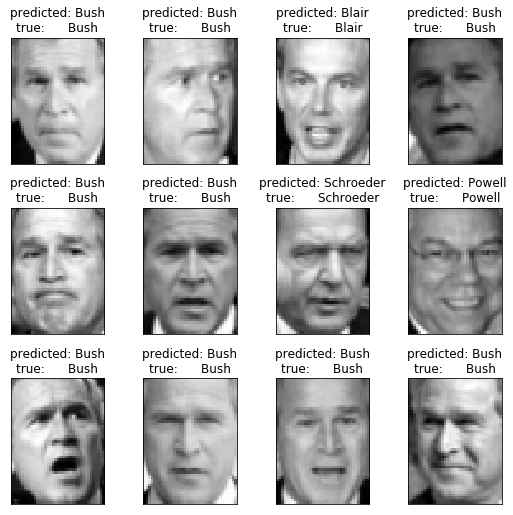

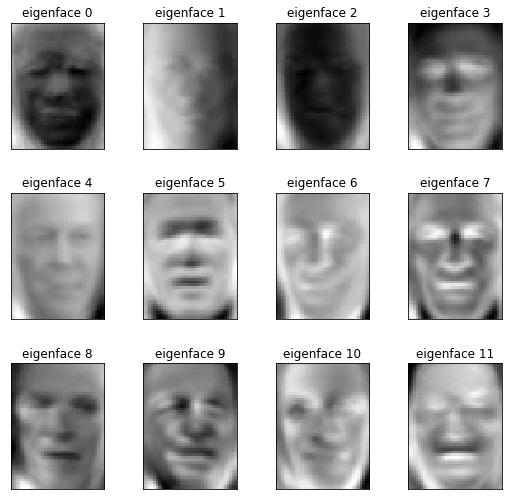

In [42]:
# plot the result of the prediction on a portion of the test set
# 将预测的结果绘制在测试集的一部分上。

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()